## Preprocessing and clustering 3k PBMCs

Single-cell RNA sequencing (scRNA-seq) is a popular and powerful technology that allows you to profile the whole transcriptome of a large number of individual cells. However, the analysis of the large volumes of data generated from these experiments requires specialised statistical and computational methods. 

Here I present an overview of the computational workflow involved in processing scRNA-seq data. 

The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics.

In [1]:
#load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [3]:
#verbosity: error (0), warnigns (1), info(2), hints (3)
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi =80, facecolor ="white")

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.1 pandas==1.3.2 scikit-learn==1.0.1 statsmodels==0.12.2 python-igraph==0.9.8 pynndescent==0.5.5


In [4]:
#set up directory
large_root = r"C:/Users/rudina/Desktop/SC_RNA_WORKSHOP"
results_file = large_root + "pbmc3k.h5ad"

In [7]:
#load the data
print("Reading data ...")
adata = sc.read_10x_mtx('/Users/rudina/Desktop/SC_RNA_WORKSHOP/data/filtered_gene_bc_matrices/hg19/',
    var_names = "gene_symbols", cache = True)

Reading data ...
... writing an h5ad cache file to speedup reading next time


In [8]:
# this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata.var_names_make_unique()  

In [9]:
#print data
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### Preprocessing

Show those genes that yield the highest fraction of counts 
 in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


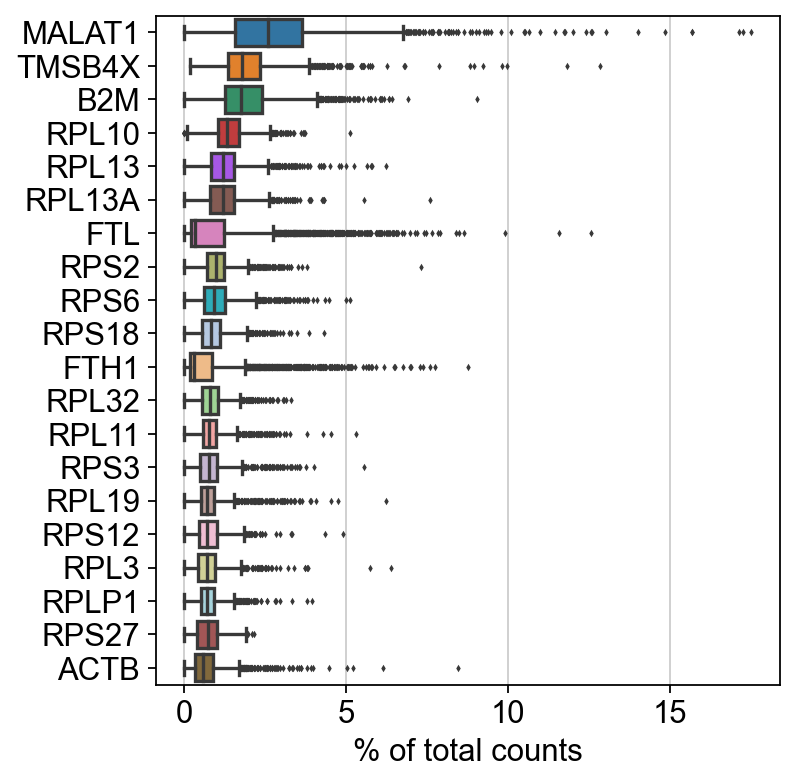

In [10]:
#show genes that yield highest fraction of counts
sc.pl.highest_expr_genes(adata, n_top =20, )

In [11]:
#Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows (Lun, McCarthy & Marioni, 2017):

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With pp.calculate_qc_metrics, we can compute many metrics very efficiently.

In [12]:
# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], 
                                       percent_top=None, log1p=False, inplace=True)

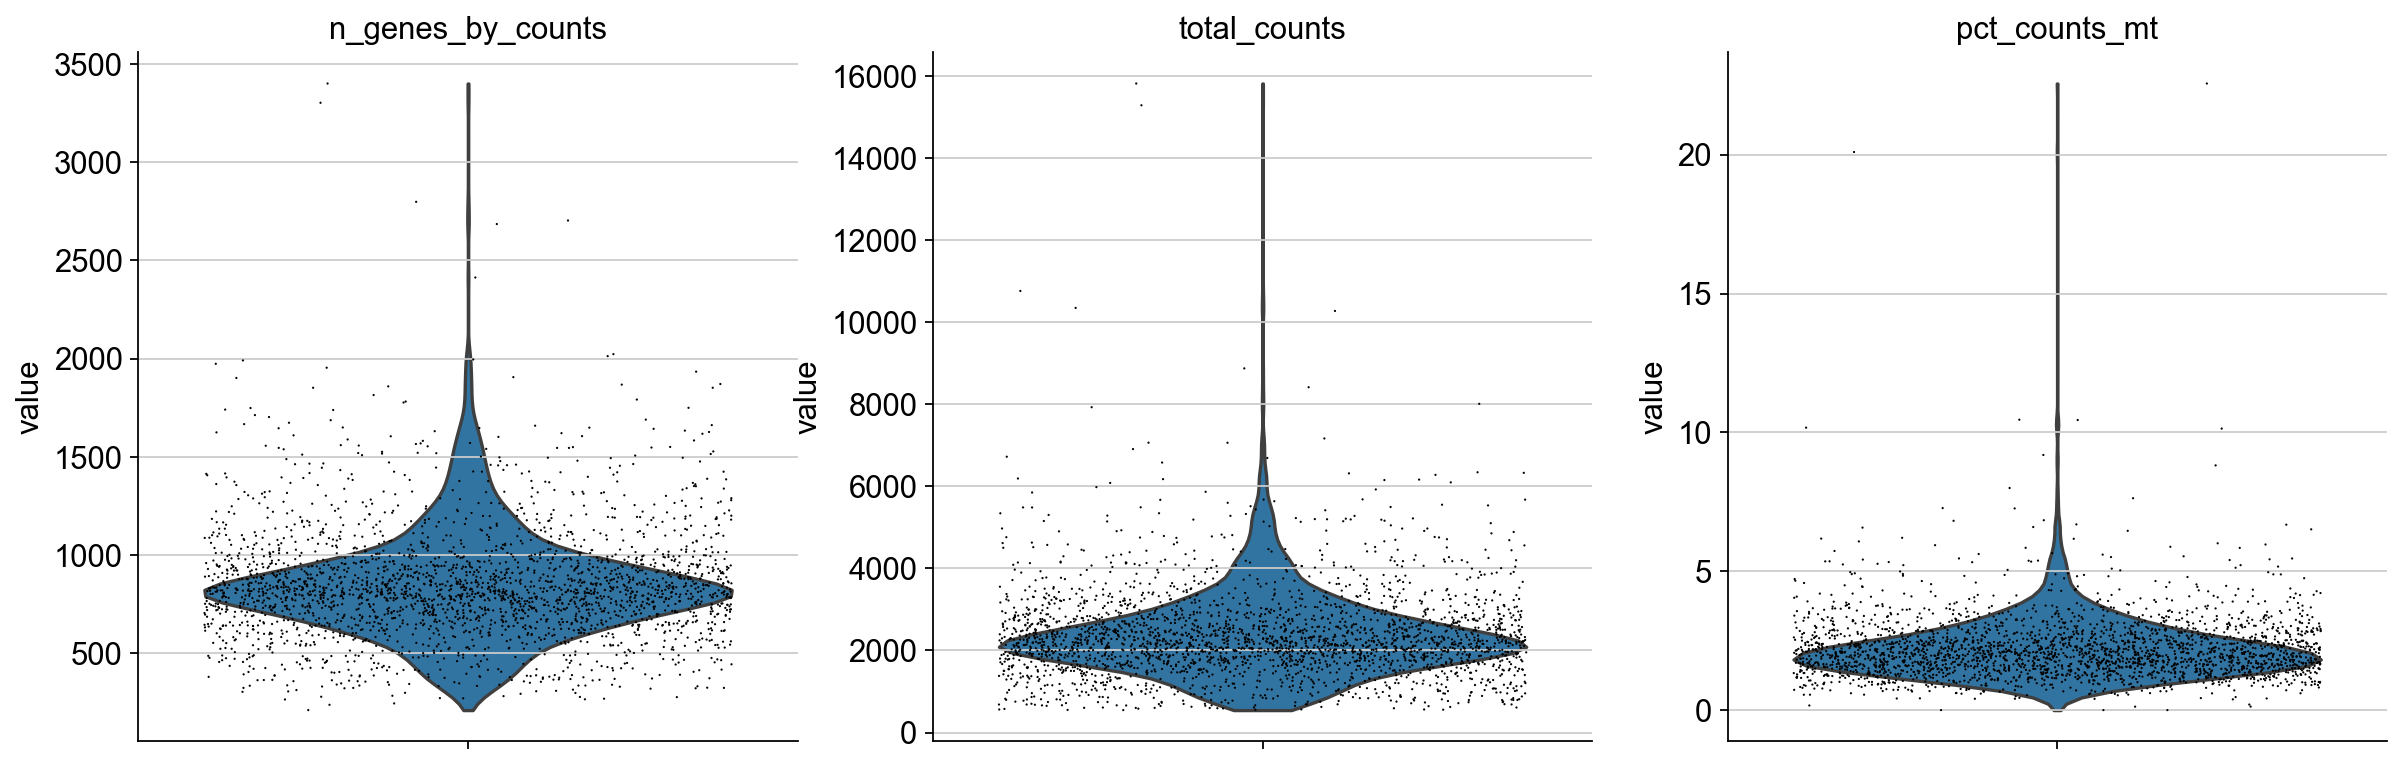

In [13]:
# A violin plot with QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

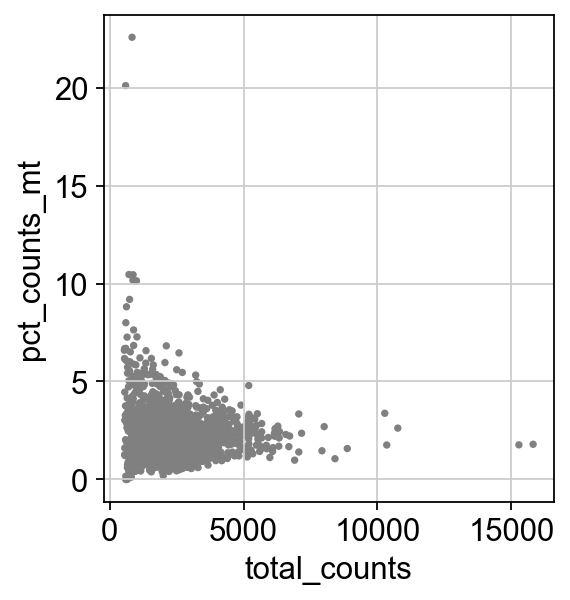

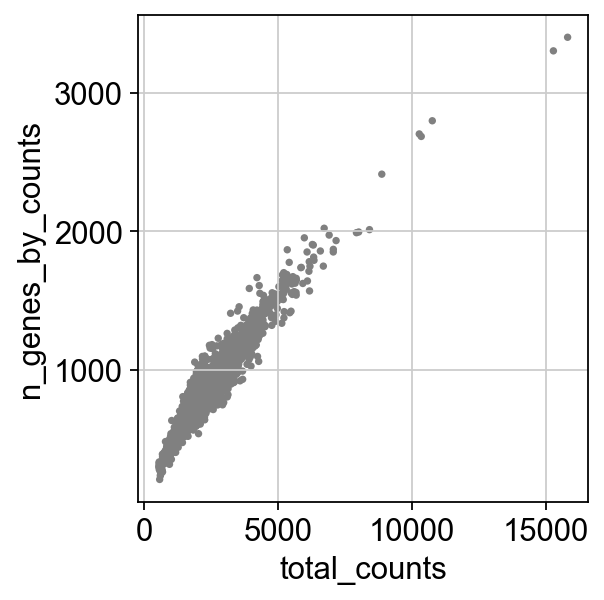

In [14]:
#Scatter plot of QC metrics

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Count'>

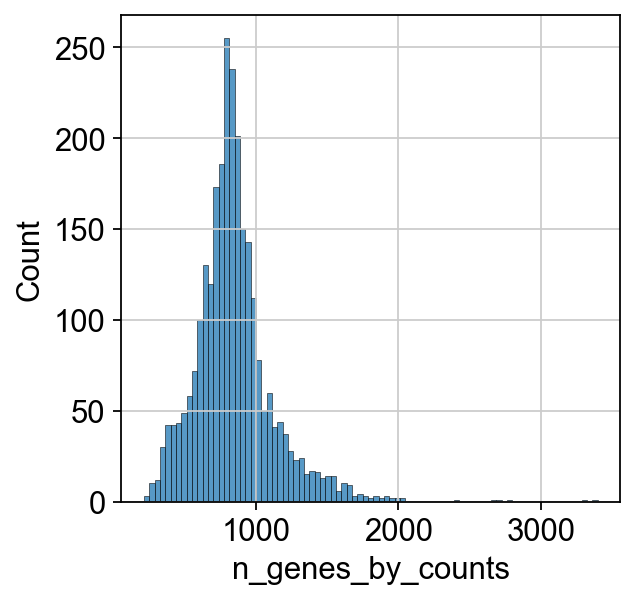

In [16]:
#plot a histogram for a single variable
sns.histplot(adata.obs['n_genes_by_counts'])

In [24]:
#save the figures as .png or .pdf
#ax = plt.gca
#plt.savefig(large_root + "/" + "QCbefore.png")

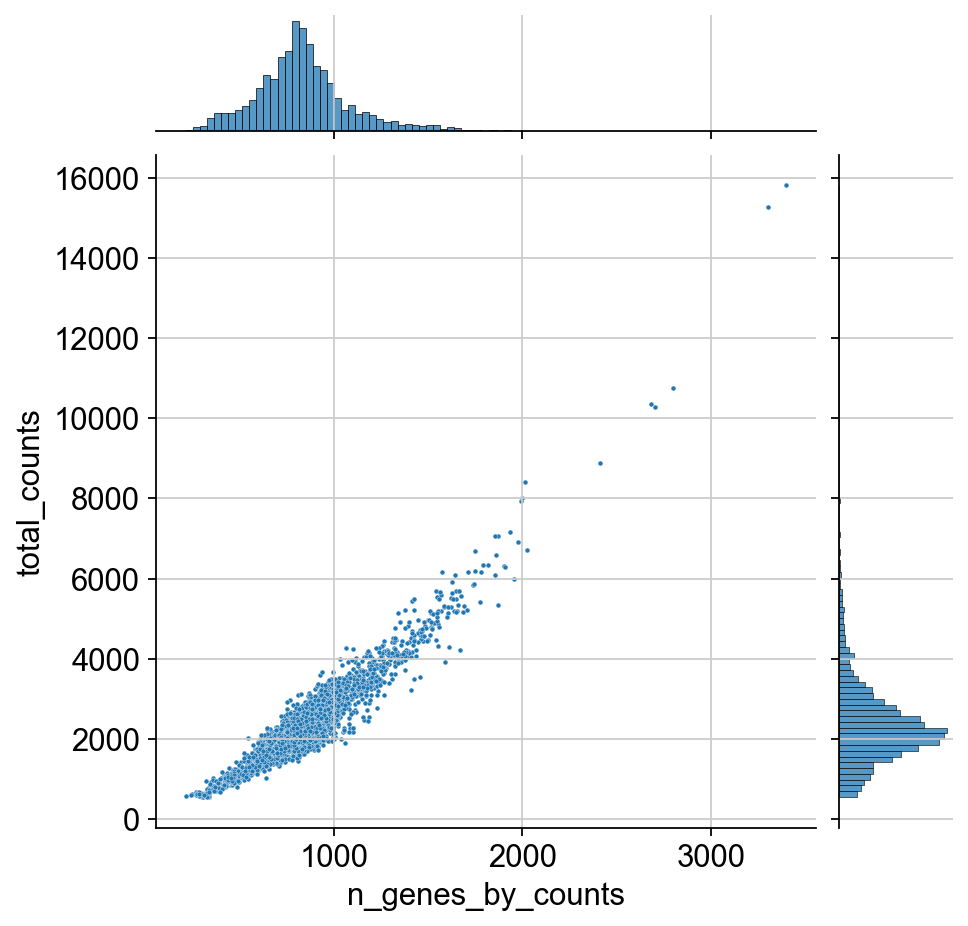

In [17]:
# To joint distribution with marginal histogram
sns.jointplot(
    x = "n_genes_by_counts",
    y = "total_counts",
    data = adata.obs,
    kind = "scatter",
    s = 5)    

In [20]:
#basic filtering
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 3)

In [22]:
#filter data by sliding the 
bdata = adata
bdata = bdata[bdata.obs.n_genes_by_counts< 2200,:]
bdata = bdata[bdata.obs.pct_counts_mt <5, :]

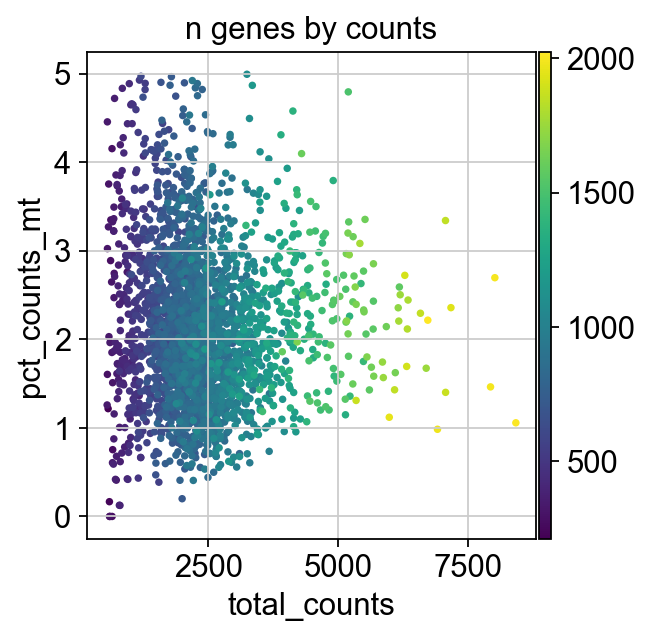

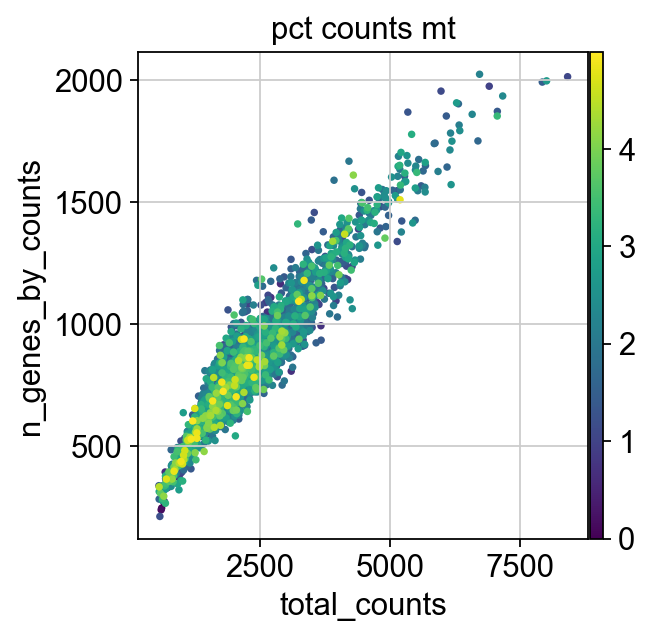

In [23]:
sc.pl.scatter(bdata, x= "total_counts", y = "pct_counts_mt", color ="n_genes_by_counts" )
sc.pl.scatter(bdata, x='total_counts', y='n_genes_by_counts', color ="pct_counts_mt")

In [28]:
# Day 2 - intall some 
!pip3 install kneed
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from kneed import KneeLocator as kl

Total-count normalize (library-size correct) the data matrix 
X
 to 10,000 reads per cell, so that counts become comparable among cells.

In [30]:
#After filtering the data, we'll perform normalisation step
norm_data = bdata.copy()
sc.pp.normalize_total(norm_data, target_sum = 1e4)

normalizing counts per cell
    finished (0:00:00)


In [31]:
#Then Log Trasformation step - log n+1
sc.pp.log1p(norm_data)

In [33]:
#Identify highly variable genes HVGs
sc.pp.highly_variable_genes(norm_data, min_mean = 0.0125, max_mean = 3,
                           min_disp = 0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


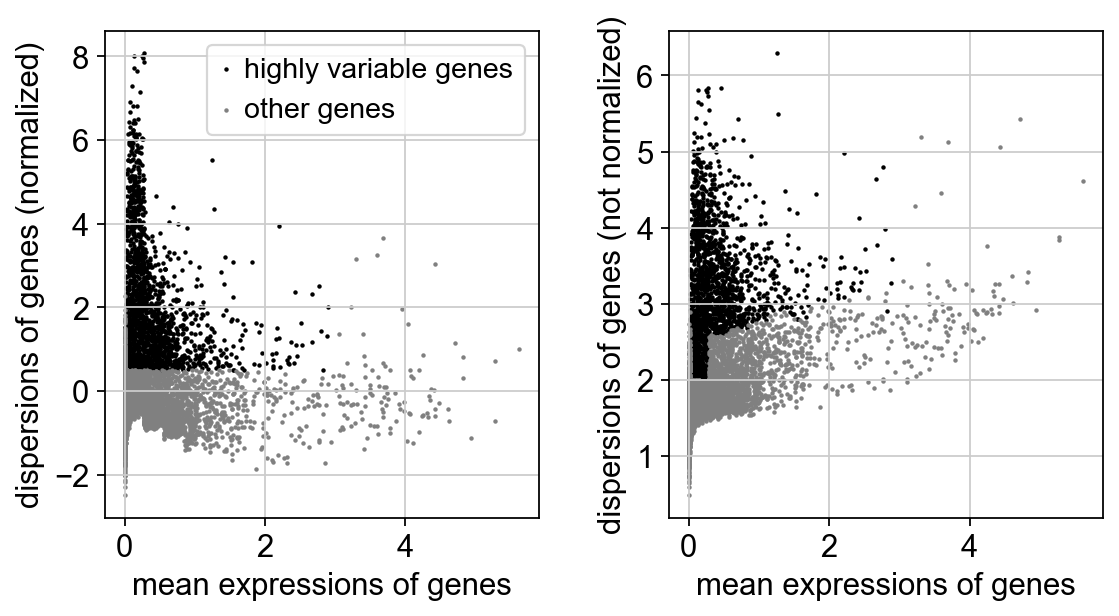

In [34]:
#Plot dispension vs expression
sc.pl.highly_variable_genes(norm_data)

In [36]:
HVG = norm_data.copy()
HVG.raw_data = HVG

In [38]:
#Filter out
HVG = HVG[:, HVG.var.highly_variable]

In [39]:
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(HVG, max_value = 10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/rudina/miniconda3/envs/mini_ds/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Principal component analysis
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [42]:
#PCA
sc.tl.pca(HVG, svd_solver = "arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


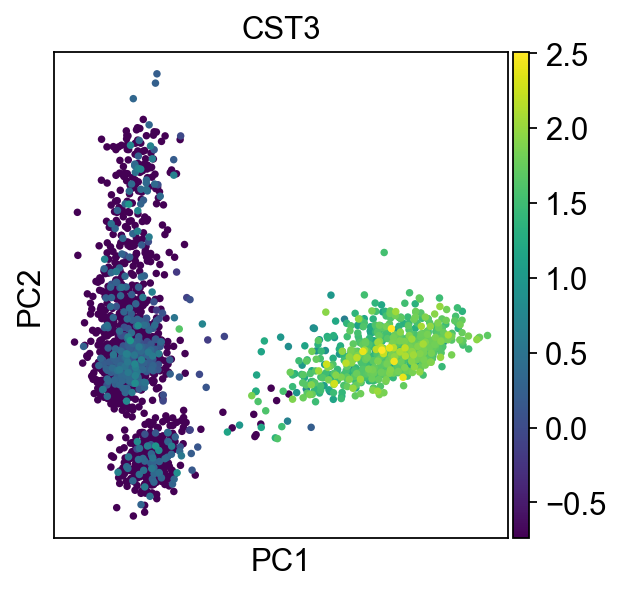

In [44]:
#We can make a scatter plot in the PCA coordinates, but we will not use that later on.
sc.pl.pca(HVG, color='CST3')#CST3 a highly expressed gene

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.

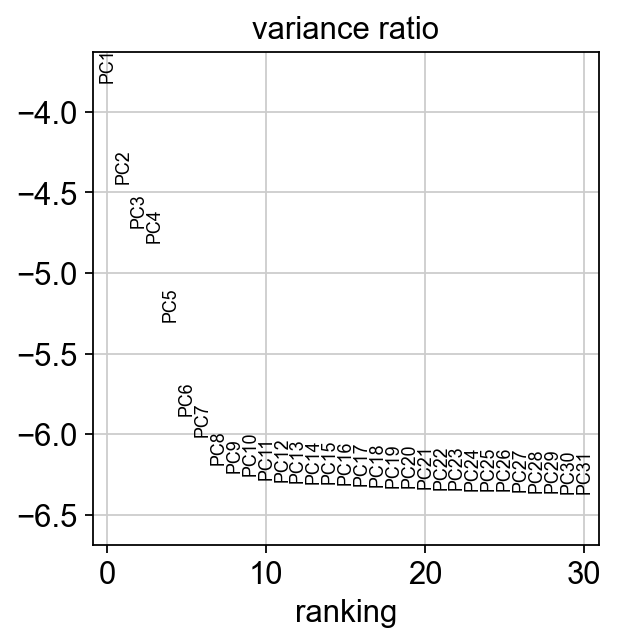

In [45]:
sc.pl.pca_variance_ratio(HVG, log=True)

/Users/rudina/miniconda3/envs/mini_ds/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/rudina/miniconda3/envs/mini_ds/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


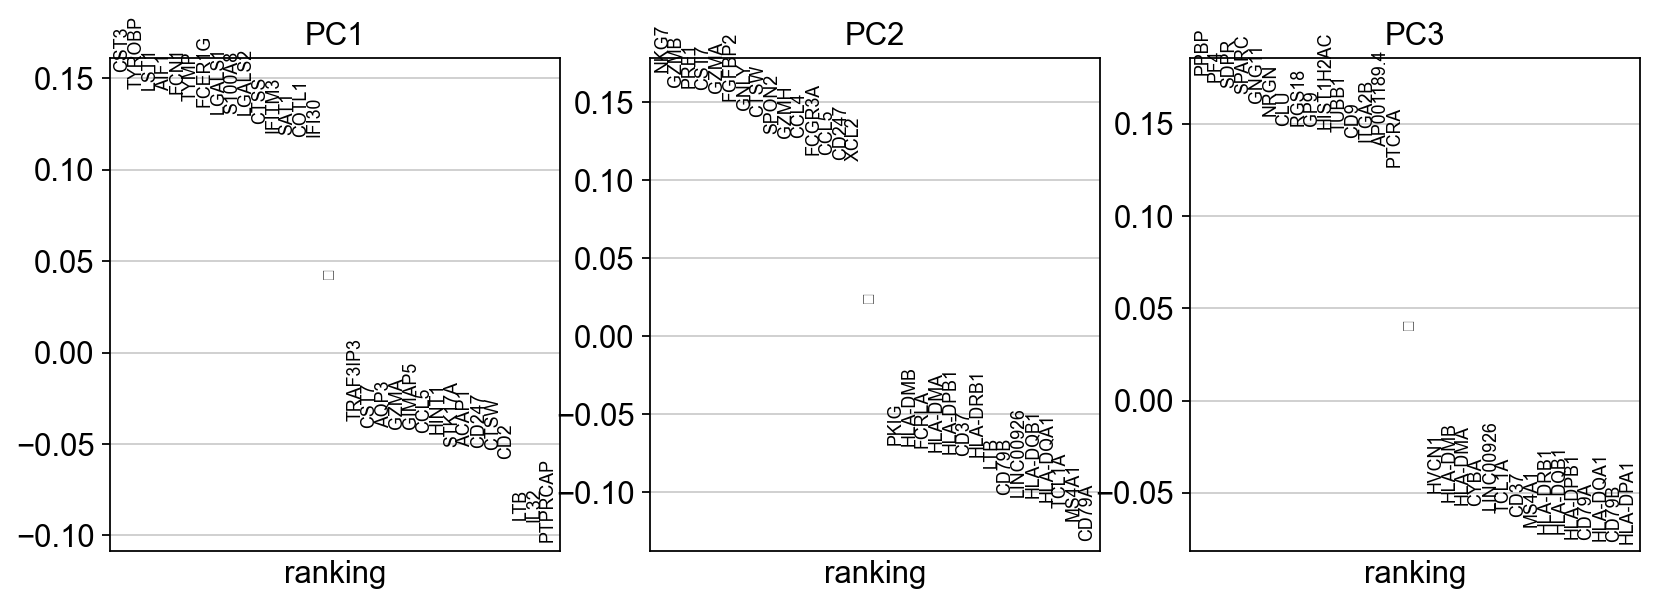

In [46]:
#plot the contribution of each gene to the PCA
sc.pl.pca_loadings(HVG)

In [59]:
#define a new fuction to find the elboe dimention of the scee plot
def PCA_Elbow_fit(data):
    model = PCA().fit(data)
    explained_variance = model.explained_variance_ratio_
    pcs = list(range(1,explained_variance.shape[0]+1))#enumarate(explained_variance,1)
    klm = kl(pcs, explained_variance, S=1.0,curve="convex", direction = "decreasing")
    pcs_used = klm.knee
    pc_list = list(range(1, pcs_used+1))
    new_data = PCA(n_components = pcs_used, svd_solver = "arpack").fit_transform(data)
    return pcs_used, new_data, pcs, explained_variance, pc_list 

In [53]:
#Extract cellxgenes data from scanpy and generate a dataframe
label = "HVG"
df = pd.DataFrame(HVG.X, index = HVG.obs_names, columns =HVG.var_names)
#df.to_csv(output_path)

In [60]:
dim,new_matrix,pc_ax,pc_ay,col_labels = PCA_Elbow_fit(df)
print(dim)

17


In [64]:
#create a new dataframe of cells x PC
columns= ["PC_" +str(i) for i in col_labels]
#ourput_path = large_root + "_PCA_"+ label + str(dim) +".csv"
pc_df = pd.DataFrame(new_matrix, index = df.index.values.tolist(), columns = columns)
pc_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17
AAACATACAACCAC-1,-4.268428,0.419719,0.250215,-2.323585,0.545037,-0.315031,1.133124,-2.022456,4.005498,-1.789815,-1.010494,2.170615,1.107197,-1.949897,1.347391,-0.954756,-0.381095
AAACATTGAGCTAC-1,-0.407248,-5.060606,-4.268579,8.206319,2.776632,2.152339,1.457468,0.618134,0.478913,0.433152,-1.692359,2.045906,3.856965,-1.835380,0.353835,-1.471907,0.969652
AAACATTGATCAGC-1,-2.037882,2.375254,0.748792,-2.153639,4.205235,-0.281777,0.550462,-2.863806,-0.457933,-0.312905,-1.957988,1.429443,-0.230162,-1.126366,2.644274,1.195217,-3.927727
AAACCGTGCTTCCG-1,10.201519,0.737322,-0.677485,0.261285,0.367401,-2.830447,0.458505,0.492335,-0.411461,1.122572,-1.360627,1.211806,-0.606528,-0.577580,-1.867968,-0.095070,-0.491879
AAACCGTGTATGCG-1,-2.481447,6.740211,-0.623770,3.601830,-7.100301,-0.886326,-4.993974,0.638878,-1.088054,-0.637383,-0.067968,2.052105,3.077773,-0.893406,1.412585,0.207985,-1.873054


In [65]:
pc_df.shape

(2637, 17)